In [1]:
!pip install tsfel

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tsfel

from custom_code.utils import load_from_tsfile_to_dataframe


In [2]:
from tsfel.utils.add_personal_features import add_feature_json

add_feature_json(r"C:\\Users\\TRETEC\\Documents\\MVA\\S1\\[AST]\\TSFEL_Review\\custom_code\\custom_feature.py",r"C:\\Users\\TRETEC\\Documents\\MVA\\S1\\[AST]\\TSFEL_Review\\custom_code\\features.json")

Feature is_it_weekend was added.


# Loading data from tseregression.org

In [3]:
TRAIN_PATH = 'regression_data/AppliancesEnergy_TRAIN.ts'
TEST_PATH = 'regression_data/AppliancesEnergy_TEST.ts'

In [4]:
Ts = 600 #s
fs = 1/Ts

In [5]:
fs=0.0016

In [6]:
X_train, y_train = load_from_tsfile_to_dataframe(TRAIN_PATH)
X_test, y_test = load_from_tsfile_to_dataframe(TEST_PATH)

0it [00:00, ?it/s]

119it [00:02, 58.75it/s]
66it [00:00, 83.81it/s] 


In [7]:
X_train.columns

Index(['dim_0', 'dim_1', 'dim_2', 'dim_3', 'dim_4', 'dim_5', 'dim_6', 'dim_7',
       'dim_8', 'dim_9', 'dim_10', 'dim_11', 'dim_12', 'dim_13', 'dim_14',
       'dim_15', 'dim_16', 'dim_17', 'dim_18', 'dim_19', 'dim_20', 'dim_21',
       'dim_22', 'dim_23'],
      dtype='object')

In [8]:
dimensions =X_train.columns
columns =['T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint']
replace_by=dict(list(zip(dimensions,columns)))
X_train.rename(columns=replace_by,inplace=True)

In [9]:
X_test.rename(columns=replace_by,inplace=True)

# 1. Exploratory Data Analysis

In [10]:
X_train_copy = X_train.copy()

In [11]:
sample = X_train_copy.iloc[0]
sample[0].index.hour

Index([17, 17, 17, 17, 17, 17, 18, 18, 18, 18,
       ...
       15, 15, 15, 15, 16, 16, 16, 16, 16, 16],
      dtype='int32', length=144)

In [12]:
time_range = pd.date_range(start='17:00', periods=24, freq='H')


Visually comparing two multivariate time series with different target values

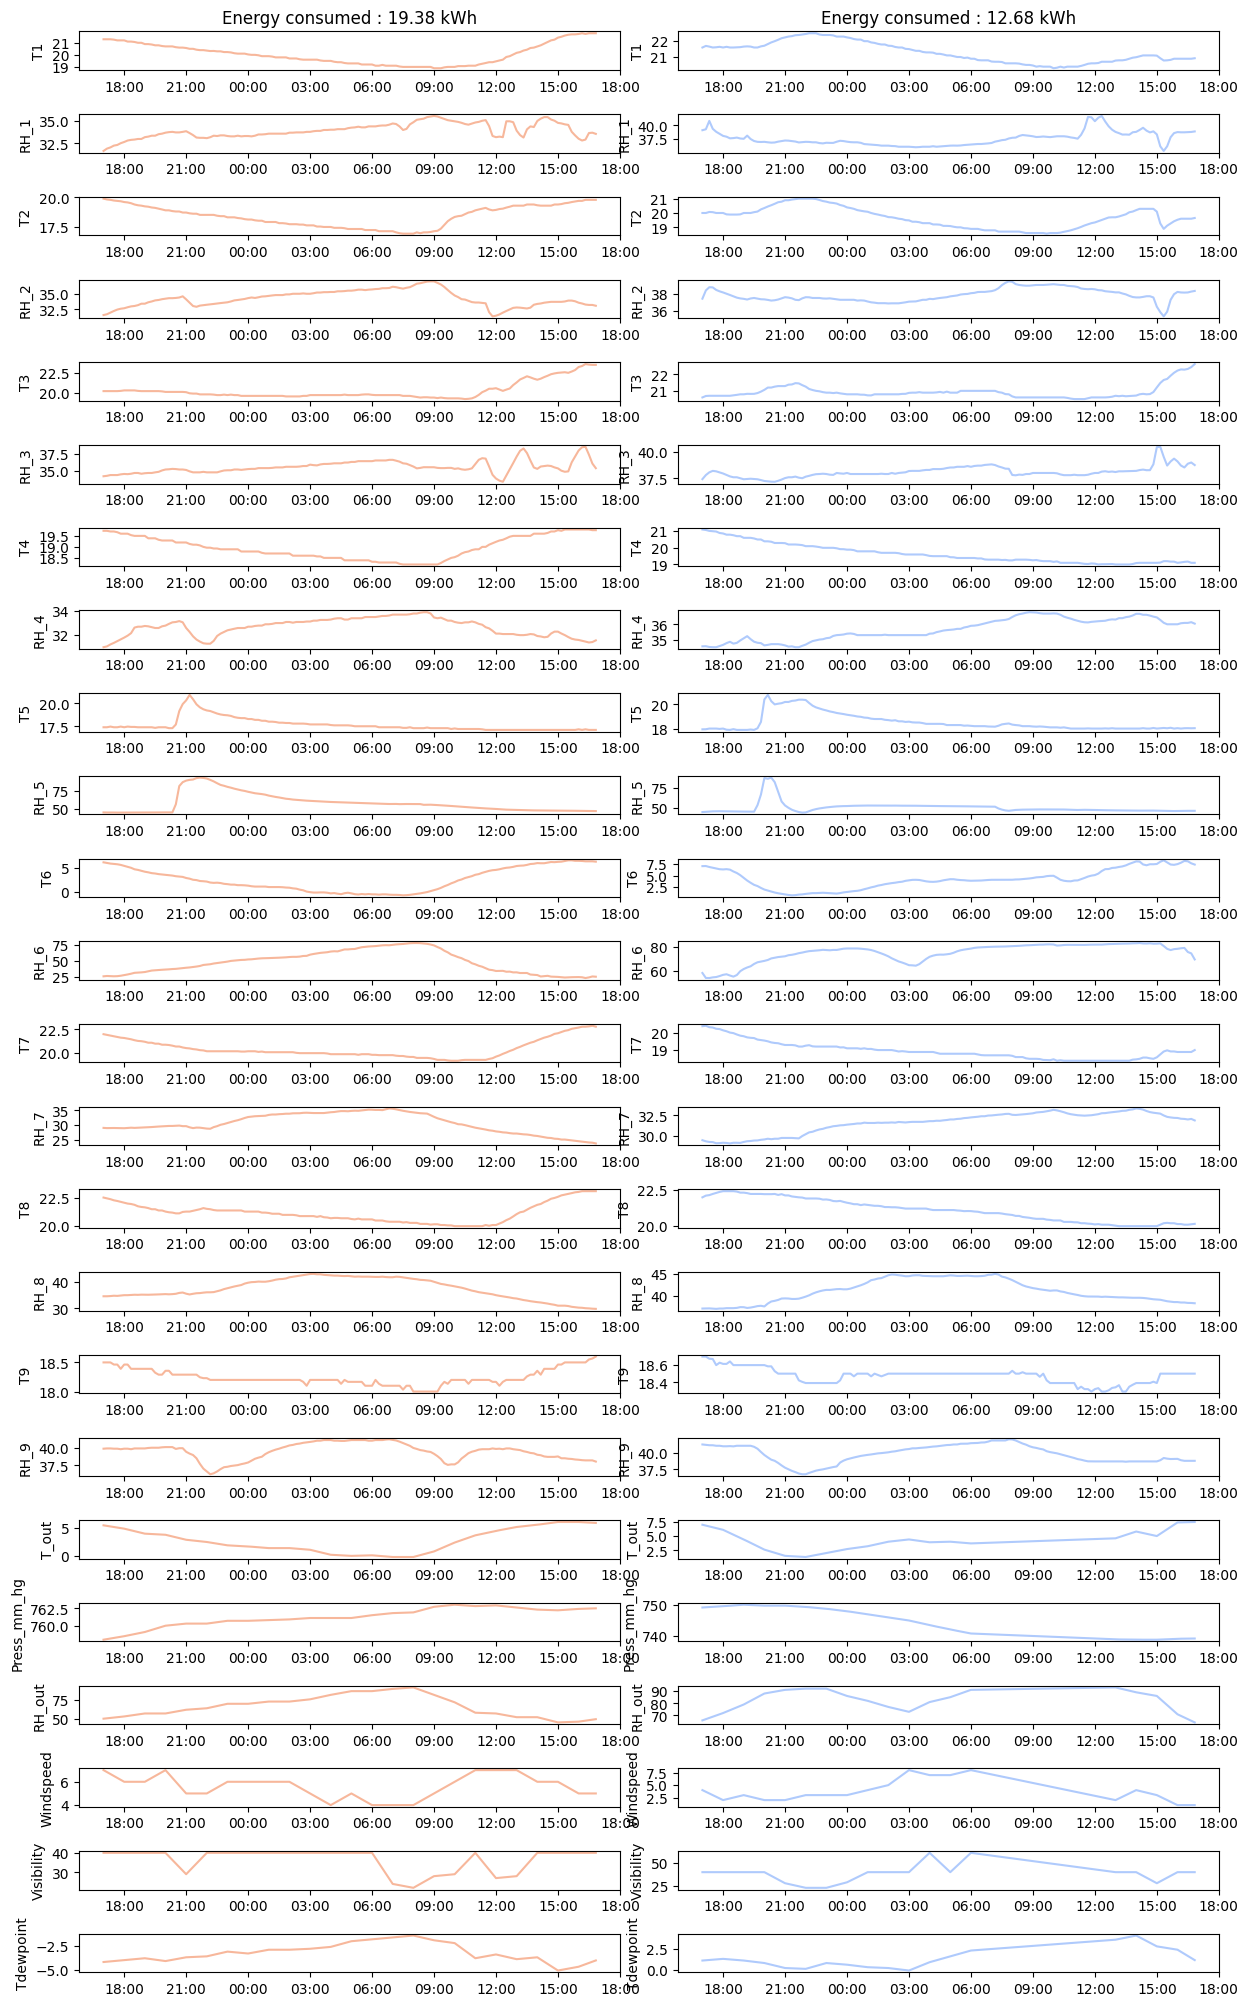

In [13]:
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.cm as cm


#First row in our trainset, a multivariate time series of 24 dimensions
samples = X_train.iloc[:2]


# Normalize y_train to a 0-1 scale
norm = mcolors.Normalize(vmin=min(y_train), vmax=max(y_train))

# Choose a colormap
cmap = cm.coolwarm #the cooler the color, the less energy consumed

fig, axes = plt.subplots(nrows=24, ncols=2, figsize=(12,20))
fig.tight_layout(w_pad=2)

for (j,sample) in list(samples.iterrows()):
    color = cmap(norm(y_train[j]))

    for i in range(24):
        axes[i,j].plot(sample[i],color=color)
        axes[i,j].set_ylabel(columns[i])
        axes[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    axes[0,j].set_title(f'Energy consumed : {y_train[j]} kWh')

# Feature extraction : TSFEL

## Testing custom feature

In [20]:
#Custom feature : is_it_weekend
cfg_custom = tsfel.get_features_by_domain(json_path='custom_code/features.json')
# cfg_custom['temporal']['is_it_weekend']
cfg_custom = {'temporal':{'is_it_weekend':cfg_custom['temporal']['is_it_weekend']}}

In [21]:
cfg_custom

{'temporal': {'is_it_weekend': {'complexity': 'constant',
   'description': '',
   'function': 'is_it_weekend',
   'parameters': {'parameters': None},
   'use': 'yes'}}}

In [22]:
tsfel.time_series_features_extractor(cfg_custom, X_train.iloc[5, 0], fs=fs, features_path='C:\\Users\\TRETEC\\Documents\\MVA\\S1\\[AST]\\TSFEL_Review\\custom_code\\custom_feature.py')

*** Feature extraction started ***



*** Feature extraction finished ***


,0_is_it_weekend
0,0


Good news is our custom feature has been successfully added. Bad news is tsfel isnt very flexible regarding input data format and feature calculation : 
1. time series that get fed to ``tsfel.time_series_features_extractor`` are automatically converted to np.array, allowing only to store time_series values but not corresponding time index, which could sometimes helpful, for extracting seasonal features. 
2. window_size argument in ``tsfel.time_series_features_extractor`` is in fact related to the samples dimension and not the temporal dimension, this is to be used when we classify segments of a time series. 

We also notice that it is somewhat laborious to extract a single specific feature (there is no options to *directly* extract features `by_id`, only in groups)

## TSFEL built-in features

In [23]:
# Get the TSFEL feature configuration
import pandas as pd
cfg = tsfel.get_features_by_domain()

In [24]:
# Extract features for each variable and concatenate them
X_train_features = []
for dim in tqdm(range(X_train.shape[1])): #iterate over dimensions
    temp_features = tsfel.time_series_features_extractor(cfg, [X_train.iloc[i, dim] for i in range(X_train.shape[0])], fs=fs)
    X_train_features.append(temp_features)

X_train_features = pd.concat(X_train_features, axis=1)
X_train_features

  0%|          | 0/24 [00:00<?, ?it/s]

*** Feature extraction started ***


  4%|▍         | 1/24 [00:04<01:53,  4.93s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


  8%|▊         | 2/24 [00:09<01:49,  4.99s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 12%|█▎        | 3/24 [00:14<01:41,  4.85s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 17%|█▋        | 4/24 [00:18<01:30,  4.50s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 21%|██        | 5/24 [00:22<01:21,  4.28s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 25%|██▌       | 6/24 [00:26<01:17,  4.30s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 29%|██▉       | 7/24 [00:31<01:13,  4.35s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 33%|███▎      | 8/24 [00:35<01:09,  4.37s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 38%|███▊      | 9/24 [00:40<01:06,  4.44s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 42%|████▏     | 10/24 [00:45<01:03,  4.57s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 46%|████▌     | 11/24 [00:49<00:58,  4.49s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 50%|█████     | 12/24 [00:53<00:53,  4.44s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 54%|█████▍    | 13/24 [00:59<00:52,  4.74s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 58%|█████▊    | 14/24 [01:03<00:45,  4.53s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 62%|██████▎   | 15/24 [01:07<00:39,  4.36s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 67%|██████▋   | 16/24 [01:11<00:34,  4.25s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 71%|███████   | 17/24 [01:15<00:29,  4.15s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 75%|███████▌  | 18/24 [01:19<00:24,  4.12s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 79%|███████▉  | 19/24 [01:23<00:20,  4.06s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 83%|████████▎ | 20/24 [01:27<00:16,  4.04s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 88%|████████▊ | 21/24 [01:31<00:12,  4.03s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 92%|█████████▏| 22/24 [01:35<00:08,  4.05s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 96%|█████████▌| 23/24 [01:39<00:04,  4.05s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


100%|██████████| 24/24 [01:44<00:00,  4.36s/it]


*** Feature extraction finished ***


,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Average power,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,...,0_Wavelet variance_0,0_Wavelet variance_1,0_Wavelet variance_2,0_Wavelet variance_3,0_Wavelet variance_4,0_Wavelet variance_5,0_Wavelet variance_6,0_Wavelet variance_7,0_Wavelet variance_8,0_Zero crossing rate
0,58010.444042,1.791287e+06,58010.444042,0.649068,44442.819779,28.0,115.0,19.100000,20.890000,0.006944,...,0.088709,0.350769,0.837373,1.606182,2.691410,4.024402,5.566248,7.368580,9.541954,0.0
1,65302.514112,1.902397e+06,65302.514112,0.730658,43463.412120,28.0,115.0,20.620000,21.921429,0.006944,...,0.007086,0.051582,0.174314,0.382618,0.753292,1.356199,2.166163,3.108274,4.130929,3.0
2,49171.064642,1.650655e+06,49171.064642,0.550166,43299.938547,28.0,115.0,18.000000,18.963333,0.006944,...,0.103434,0.398139,0.900777,1.589757,2.496321,3.717259,5.345789,7.470880,10.164421,0.0
3,62981.336469,1.867788e+06,62981.336469,0.704686,44690.245306,28.0,115.0,20.200000,21.666667,0.006944,...,0.008498,0.066407,0.196446,0.365845,0.577614,0.882709,1.371380,2.140581,3.259513,3.0
4,66518.752034,1.919477e+06,66518.752034,0.744266,43234.671465,28.0,115.0,20.666667,22.260000,0.006944,...,0.057545,0.249332,0.635278,1.163635,1.815623,2.650329,3.697770,4.979119,6.549902,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,67199.664458,1.929427e+06,67199.664458,0.751884,43732.527725,28.0,115.0,20.790000,22.356667,0.006944,...,0.170029,0.610107,1.348842,2.493506,4.271435,6.943182,10.709968,15.680119,21.868972,0.0
91,85668.469928,2.178651e+06,85668.469928,0.958528,45002.924252,28.0,115.0,23.700000,24.856667,0.006944,...,0.191862,0.878697,2.476682,4.723998,7.720473,11.742593,16.567609,21.763664,27.119138,0.0
92,60350.306881,1.828613e+06,60350.306881,0.675248,43125.218174,28.0,115.0,19.760000,21.200000,0.006944,...,0.008715,0.110305,0.445263,1.096116,2.065490,3.253503,4.552441,5.902513,7.272874,6.0
93,59983.244269,1.823376e+06,59983.244269,0.671141,44371.218297,28.0,115.0,19.790000,21.000000,0.006944,...,0.008138,0.079716,0.338323,0.868468,1.738544,3.025818,4.776782,6.949264,9.396558,6.0


In [25]:
X_test_features = []
for dim in tqdm(range(X_test.shape[1])): #iterate over dimensions
    temp_features = tsfel.time_series_features_extractor(cfg, [X_test.iloc[i, dim] for i in range(X_test.shape[0])], fs=fs)
    X_test_features.append(temp_features)

X_test_features = pd.concat(X_test_features, axis=1)
X_test_features

  0%|          | 0/24 [00:00<?, ?it/s]

*** Feature extraction started ***


  4%|▍         | 1/24 [00:05<02:09,  5.63s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


  8%|▊         | 2/24 [00:11<02:00,  5.48s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 12%|█▎        | 3/24 [00:16<01:52,  5.37s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 17%|█▋        | 4/24 [00:21<01:46,  5.31s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 21%|██        | 5/24 [00:26<01:40,  5.31s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 25%|██▌       | 6/24 [00:32<01:35,  5.32s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 29%|██▉       | 7/24 [00:37<01:29,  5.28s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 33%|███▎      | 8/24 [00:42<01:23,  5.23s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 38%|███▊      | 9/24 [00:47<01:16,  5.09s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 42%|████▏     | 10/24 [00:51<01:08,  4.91s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 46%|████▌     | 11/24 [00:56<01:01,  4.75s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 50%|█████     | 12/24 [01:00<00:55,  4.59s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 54%|█████▍    | 13/24 [01:04<00:49,  4.47s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 58%|█████▊    | 14/24 [01:08<00:43,  4.38s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 62%|██████▎   | 15/24 [01:12<00:38,  4.31s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 67%|██████▋   | 16/24 [01:17<00:34,  4.27s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 71%|███████   | 17/24 [01:21<00:29,  4.24s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 75%|███████▌  | 18/24 [01:25<00:25,  4.21s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 79%|███████▉  | 19/24 [01:29<00:21,  4.22s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 83%|████████▎ | 20/24 [01:33<00:16,  4.22s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 88%|████████▊ | 21/24 [01:38<00:12,  4.24s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 92%|█████████▏| 22/24 [01:42<00:08,  4.24s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


 96%|█████████▌| 23/24 [01:46<00:04,  4.25s/it]


*** Feature extraction finished ***
*** Feature extraction started ***


100%|██████████| 24/24 [01:50<00:00,  4.62s/it]


*** Feature extraction finished ***


,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Average power,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,...,0_Wavelet variance_0,0_Wavelet variance_1,0_Wavelet variance_2,0_Wavelet variance_3,0_Wavelet variance_4,0_Wavelet variance_5,0_Wavelet variance_6,0_Wavelet variance_7,0_Wavelet variance_8,0_Zero crossing rate
0,71524.253008,1.990781e+06,71524.253008,0.800271,43295.717355,28.00,115.00,21.426667,23.066667,0.006944,...,0.241875,0.965049,2.240252,4.072122,6.504458,9.444516,12.839085,16.709848,21.170486,0.0
1,64108.213432,1.885295e+06,64108.213432,0.717295,44389.059028,28.00,115.00,20.675000,21.500000,0.006944,...,0.073847,0.299108,0.714726,1.342794,2.184683,3.207082,4.314118,5.432603,6.578164,1.0
2,61961.945464,1.851379e+06,61961.945464,0.693281,42018.957996,28.00,115.00,19.500000,22.000000,0.006944,...,0.075609,0.278831,0.628721,1.131801,1.832968,2.810014,4.079732,5.555220,7.080441,0.0
3,71460.083111,1.990531e+06,71460.083111,0.799553,44446.031696,28.00,115.00,21.790000,22.600000,0.006944,...,0.290310,1.353879,3.016232,5.062382,7.894164,12.188465,18.009520,24.840950,32.115048,0.0
4,68269.850070,1.945298e+06,68269.850070,0.763858,44687.099286,28.00,115.00,21.323333,22.200000,0.006944,...,0.288321,1.445026,4.382131,8.112324,11.191746,13.816890,17.103168,22.207224,30.020994,0.0
5,63988.100356,1.883591e+06,63988.100356,0.715951,43841.725777,28.00,115.00,20.600000,21.500000,0.006944,...,0.016955,0.149204,0.454327,0.788583,1.061056,1.304067,1.572633,1.885839,2.267717,5.0
6,73795.821494,2.022909e+06,73795.821494,0.825688,44407.770747,28.00,115.00,22.290000,22.890000,0.006944,...,0.086887,0.440330,1.365214,2.432054,3.365505,4.436695,5.915138,7.848800,10.174418,0.0
7,67029.407890,1.926739e+06,67029.407890,0.749979,43192.828167,28.00,115.00,20.790000,22.500000,0.006944,...,0.400212,1.384173,2.932352,5.036449,7.671278,10.750996,14.247490,18.228435,22.782810,0.0
8,63472.030235,1.875352e+06,63472.030235,0.710177,43840.848187,28.00,115.00,20.200000,21.600000,0.006944,...,0.015678,0.103571,0.327738,0.658878,1.047943,1.492794,1.985035,2.491999,2.996580,0.0
9,67221.050925,1.929600e+06,67221.050925,0.752124,42757.581412,28.00,115.00,20.700000,22.500000,0.006944,...,0.067502,0.246967,0.534050,0.942795,1.510915,2.280523,3.259235,4.461012,5.926001,0.0


In [26]:
# find columns where train_features contains NaN values
nan_columns = X_train_features.columns[X_train_features.isna().any()].tolist()
X_train_features.drop(nan_columns, axis=1, inplace=True)

In [27]:
X_test_features.drop(nan_columns, axis=1, inplace=True)

In [28]:
X_train_features.shape

(95, 4896)

In [29]:
zero_std_features = X_train_features.columns[X_train_features.std() ==0]
num_zero_std_features = len(zero_std_features)

print(f"Number of features with standard deviation equal to zero: {num_zero_std_features}")
print("Features with standard deviation equal to zero:")
print(zero_std_features)

Number of features with standard deviation equal to zero: 480
Features with standard deviation equal to zero:
Index(['0_ECDF_0', '0_ECDF_1', '0_ECDF_3', '0_ECDF_4', '0_ECDF_7', '0_ECDF_8',
       '0_ECDF_9', '0_Histogram_0', '0_Histogram_1', '0_Histogram_2',
       ...
       '0_ECDF Percentile Count_0', '0_ECDF Percentile Count_1', '0_ECDF_0',
       '0_ECDF_1', '0_ECDF_3', '0_ECDF_4', '0_ECDF_7', '0_ECDF_8', '0_ECDF_9',
       '0_Human range energy'],
      dtype='object', length=480)


In [30]:
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing

# Remove low variance features
selector = VarianceThreshold()
X_train_features_selected = selector.fit_transform(X_train_features)

In [31]:
X_test_features_selected = pd.DataFrame(selector.transform(X_test_features))

In [32]:
X_train_features_selected=pd.DataFrame(X_train_features_selected,)
print(X_train_features_selected.shape)
corr_features = tsfel.correlated_features(X_train_features_selected)
len(corr_features)

(95, 4344)


1823

In [33]:
# Highly correlated features are removed
# X_train_features_selected.drop(corr_features, axis=1, inplace=True)
# X_test_features_selected.drop(corr_features, axis=1, inplace=True)


# Normalising Features
scaler = preprocessing.MinMaxScaler()
nX_train_features_selected = pd.DataFrame(scaler.fit_transform(X_train_features_selected))
nX_test_features_selected = pd.DataFrame(scaler.transform(X_test_features_selected))

In [34]:
nX_train_features_selected.shape

(95, 4344)

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize and train a random forest regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(nX_train_features_selected, y_train)

# Make predictions on the test set and evaluate the model
y_pred = regressor.predict(nX_test_features_selected)
mse = mean_squared_error(y_test, y_pred)

# Results
mse

4.971311249761898

0.8673747132631574

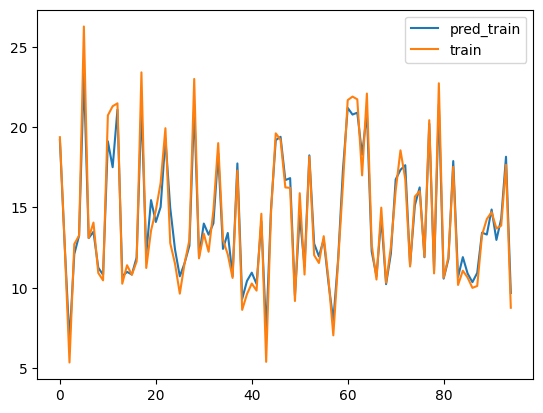

In [38]:
y_pred_train = regressor.predict(nX_train_features_selected)
plt.plot(y_pred_train, label = 'pred_train')
plt.plot(y_train, label='train')
plt.legend()
mse = mean_squared_error(y_train, y_pred_train)
mse

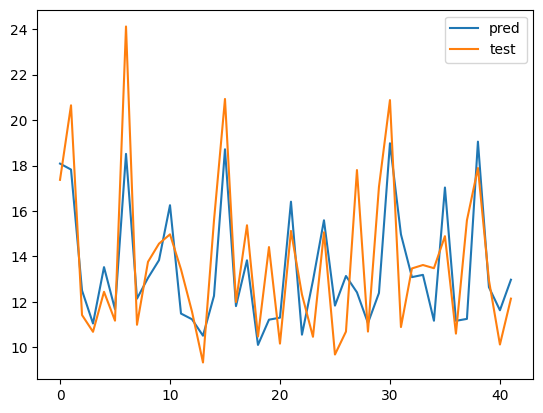

In [40]:
plt.plot(y_pred, label = 'pred')
plt.plot(y_test, label='test')
plt.legend()

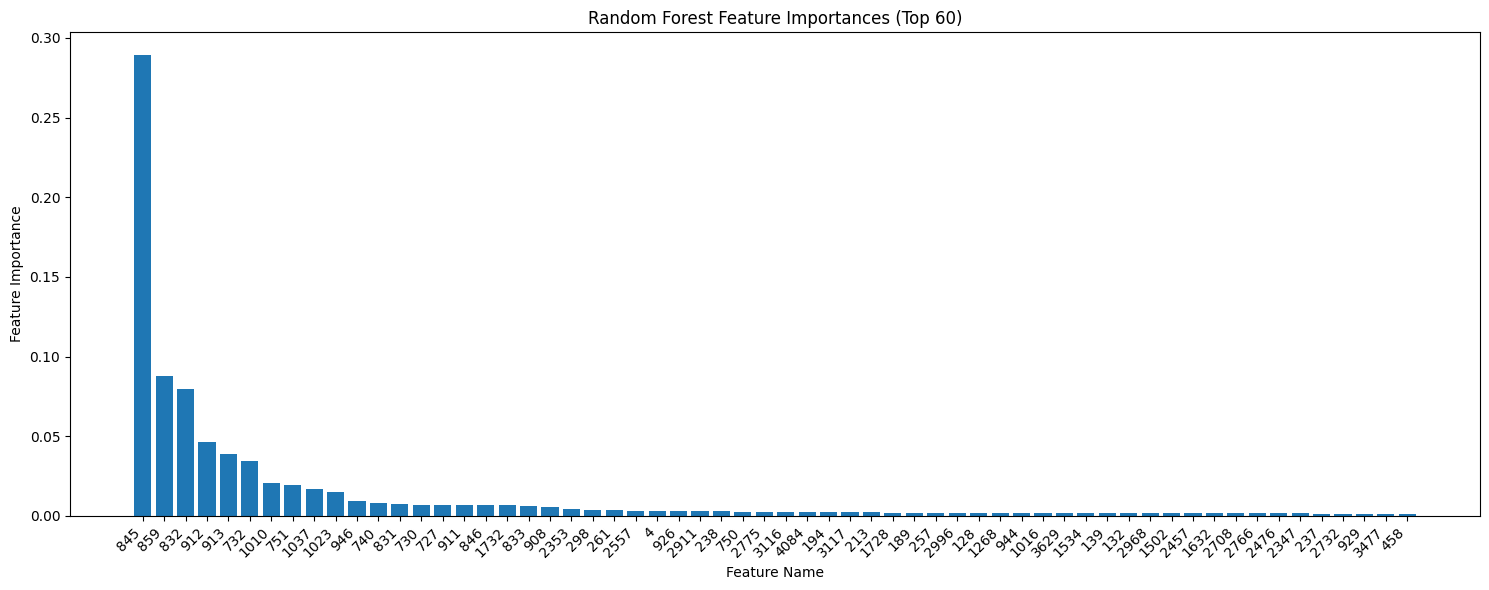

In [60]:

feature_names = nX_train_features_selected.columns.tolist()
feature_importances = regressor.feature_importances_

# Sort indices based on feature importance
indices = np.argsort(feature_importances)[::-1]

# Plotting the feature importances with feature names
# Plotting the feature importances for the first 60 features
plt.figure(figsize=(15, 6))
plt.bar(range(60), feature_importances[indices][:60], align="center")
plt.xticks(range(60), [feature_names[i] for i in indices][:60], rotation=45, ha="right")
plt.xlabel("Feature Name")
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importances (Top 60)")
plt.tight_layout()
plt.show()

In [61]:
features=[feature_names[i] for i in indices][:5]

In [ ]:
%pip install xgboost

In [58]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'colsample_bytree': [0.3, 0.5, 0.7, 1],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': [0.5, 0.7, 1],
    'alpha': [0, 0.1, 0.5, 1]
}
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror')

random_search = RandomizedSearchCV(xgb_reg, param_distributions=param_dist, 
                                   n_iter=25, scoring='neg_mean_squared_error', 
                                   cv=3, verbose=1, random_state=42)

x_train_post_RF = nX_train_features_selected
x_test_post_RF = nX_test_features_selected

random_search.fit(x_train_post_RF, y_train)

# Make predictions on the test set and evaluate the random_search
y_pred = random_search.predict(x_test_post_RF)
mse = mean_squared_error(y_test, y_pred)

# Results
mse

Fitting 3 folds for each of 25 candidates, totalling 75 fits


4.182108440849038

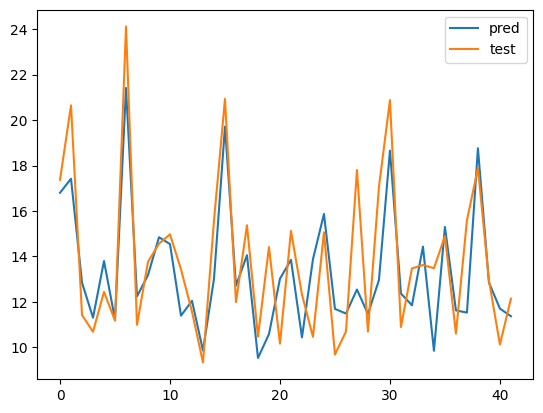

In [59]:
plt.plot(y_pred, label = 'pred')
plt.plot(y_test, label='test')
plt.legend()

## Handcrafting features
 